In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
aisles = pd.read_csv('data/aisles.csv')
aisles

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


In [3]:
dept = pd.read_csv('data/departments.csv')
dept.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
dept.department.unique()   # 21 categories in total

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

In [5]:
order_pri = pd.read_csv('data/order_products__prior.csv')
print(order_pri.shape)

(32434489, 4)


In [6]:
order_tr = pd.read_csv('data/order_products__train.csv')
print(order_tr.shape)
order_tr.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Since we are interested in customer profile analysis rather than predicting what items they would purchase in the future, we combine prior and train into one dataset

In [7]:
order_prod = pd.concat([order_pri,order_tr])
order_prod.shape

(33819106, 4)

In [8]:
prod = pd.read_csv('data/products.csv')
print(prod.shape)
prod.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
# add product information to order_prod dataset
order_prod = pd.merge(order_prod, prod, how='left', on='product_id')
order_prod.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [10]:
del order_pri, order_tr, prod

In [11]:
orders = pd.read_csv('data/orders.csv')
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
orders['user_id'].nunique() # number of users that have placed an order

206209

In [13]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

1. We only use prior and train data for analysis. Drop data where eval_set == test

2. Columns after eval_set are irrelevant with purchased items analysis, will leave for the next part (order placement pattern)

In [14]:
test_idx = orders.loc[orders['eval_set'] == 'test'].index.tolist()
orders = orders.drop(test_idx)
orders['eval_set'].unique()

array(['prior', 'train'], dtype=object)

Check whether the order id in **order_prod** and **orders** match each other

In [15]:
np.sort(order_prod.order_id.unique())

array([      1,       2,       3, ..., 3421081, 3421082, 3421083])

In [16]:
np.sort(orders.order_id.unique())

array([      1,       2,       3, ..., 3421081, 3421082, 3421083])

In [17]:
# Merge all the useful data to one dataframe
df = pd.merge(orders,order_prod,how='outer',on='order_id')
df = pd.merge(df,dept,on='department_id')

In [18]:
df.loc[df.user_id == 1,:].sort_values(by='order_number')

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,beverages
11441654,2539329,1,prior,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household
8435243,2539329,1,prior,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks
8435242,2539329,1,prior,1,2,8,NaN,12427,3,0,Original Beef Jerky,23,19,snacks
2804175,2539329,1,prior,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804190,1187899,1,train,11,4,8,14.0,27845,9,0,Organic Whole Milk,84,16,dairy eggs
2804191,1187899,1,train,11,4,8,14.0,49235,10,1,Organic Half & Half,53,16,dairy eggs
2804188,1187899,1,train,11,4,8,14.0,25133,2,1,Organic String Cheese,21,16,dairy eggs
8435266,1187899,1,train,11,4,8,14.0,26088,8,1,Aged White Cheddar Popcorn,23,19,snacks


In [19]:
del order_prod,orders
gc.collect()

0

In [20]:
# drop columns that are redundant or not useful at current point
df = df.drop(['eval_set','order_dow','order_hour_of_day','days_since_prior_order',
              'add_to_cart_order','aisle_id','department_id'],axis=1)

df.head()

,order_id,user_id,order_number,product_id,reordered,product_name,department
0,2539329,1,1,196,0,Soda,beverages
1,2398795,1,2,196,1,Soda,beverages
2,473747,1,3,196,1,Soda,beverages
3,2254736,1,4,196,1,Soda,beverages
4,431534,1,5,196,1,Soda,beverages


In [21]:
df.shape

(33819106, 7)

# EDA

### number of orders placed

<AxesSubplot: ylabel='Count'>

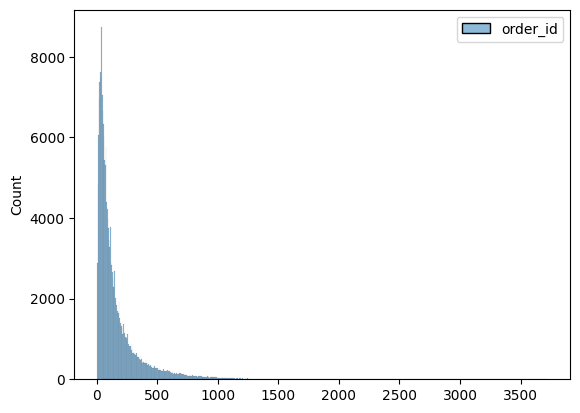

In [22]:
order_by_user = df.groupby('user_id').agg({'order_id':'count'})
sns.histplot(order_by_user)

### product analysis
1. number of products by department 
2. sales amount by product and by department (some products are not comparable due to their nature. sadly we don't have price data) 
3. best-sellers by department

In [23]:
dept_list = df.department.unique().tolist()
num_dept = len(dept_list)
print(dept_list)

['beverages', 'dairy eggs', 'snacks', 'household', 'produce', 'breakfast', 'pantry', 'deli', 'frozen', 'personal care', 'meat seafood', 'international', 'bakery', 'canned goods', 'dry goods pasta', 'alcohol', 'pets', 'babies', 'other', 'missing', 'bulk']


In [24]:
df.loc[df.department == 'missing',:]['product_name'].unique()

array(['Strained Non-Fat Strawberry Icelandic Style Skyr Yogurt',
       'Cilantro Bunch', 'Whole Grain Thin Spaghetti', ...,
       'Strawberry Shampoo', 'Water With Electrolytes',
       'Sweetart Jelly Beans'], dtype=object)

In [25]:
df.loc[df.department == 'bulk',:]['product_name'].unique()

array(['Dried Mango', 'Organic Rolled Oats', 'Apricots',
       'Vegetable Chips', 'Organic Black Mission Figs',
       'Organic Hemp Plus Granola', 'Organic Quick Rolled Oats',
       'Rolled Oats', 'Organic Short Brown Sprouted Rice',
       'Israeli Couscous', 'Organic Royal Rainbow Quinoa',
       'Large Ataulfo Mango', 'Organic Split Green Peas',
       'Wild Rice Blend', 'Pesto Sauce', 'Whole Medjool Dates',
       'Organic Red Kidney Beans', 'Organic Pearled Barley',
       'Turkish Apricots', 'Organic Turkish Apricots',
       'Organic Mung Beans', 'Cranberry Beans',
       'Organic Blueberries Package', 'Madagascar Pink Rice',
       'Organic Brown Jasmine Rice', 'Organic Hunza Golden Raisins',
       'Organic Raspberry Muesli', 'Crystallized Ginger Chunks',
       'Organic Magic Muesli', 'Organic Roasted Buckwheat (Kasha)',
       'Naturally Sweet Plantain Chips', 'Organic Brown Basmati Rice',
       'Organic Honey Lavender Granola',
       'Fit Super A Juice, Cold Pressed, C

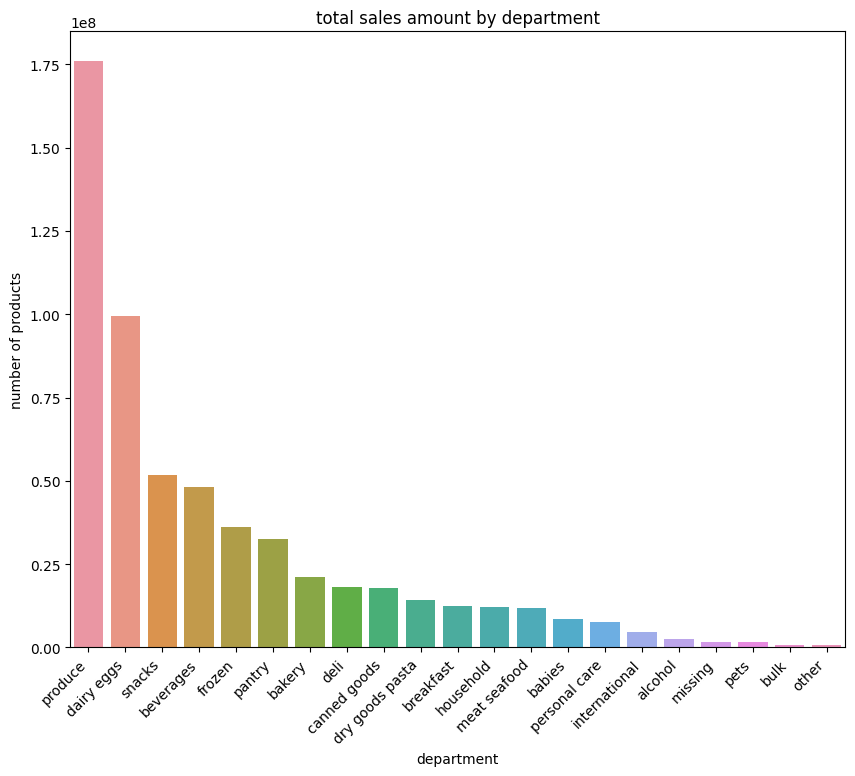

In [26]:
# sales amount by department
prod1 = df.groupby('department').agg({'order_number':'sum'}).reset_index().sort_values(by='order_number',ascending=False)

plt.figure(figsize = (10,8))
sns.barplot(prod1,x='department',y='order_number');
plt.title('total sales amount by department')
plt.ylabel('number of products')
plt.xticks(rotation=45, ha='right');

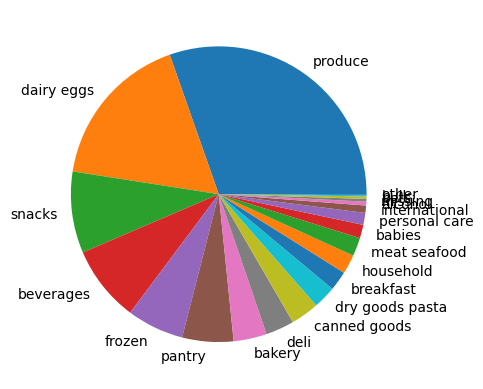

In [27]:
plt.pie(prod1['order_number'],labels = prod1['department']);

In [28]:
def best_sellers(df,k):
    df = df.groupby('product_name').agg({'product_id':'count'}).reset_index().sort_values(by='product_id',ascending=False)
    df = df.iloc[:k,:]
    
    plt.figure(figsize = (8,6))
    sns.barplot(df,x='product_name',y='product_id');
    plt.title('total sales amount by product')
    plt.ylabel('number of products sold')
    plt.xticks(rotation=45,ha='right');


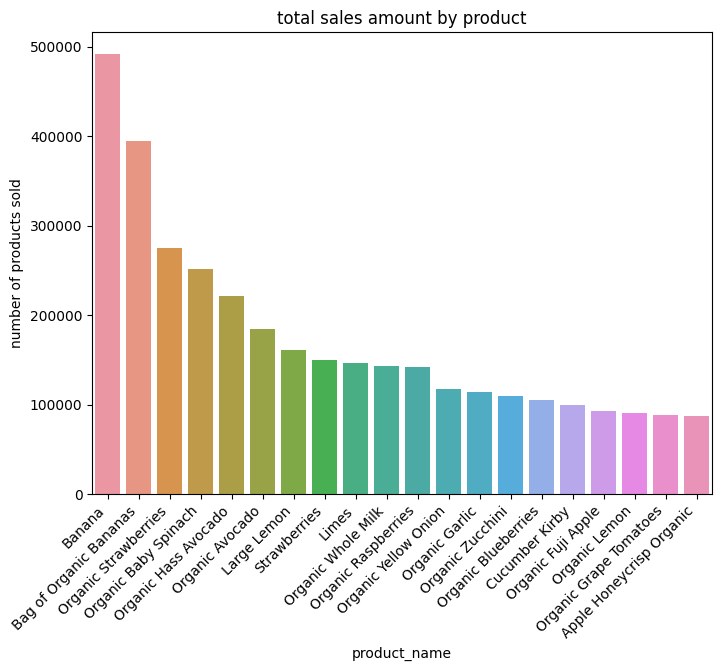

In [29]:
best_sellers(df,20)

Seems like American believe in organic foods

In [30]:
# helper function
def best_sellers_dept(df, dept, k):
    df = df.loc[df.department==dept,:]
    
    df = df.groupby('product_name').agg({'order_number':'sum'}).reset_index().sort_values(by='order_number',ascending=False)
    df = df.iloc[:k,:]
    
    plt.figure(figsize = (6,4))
    sns.barplot(df,x='product_name',y='order_number');
    plt.title(dept)
    plt.ylabel('number of products sold')
    plt.xticks(rotation=45,ha='right');

Now let's plot the popular products of high sales departments. 

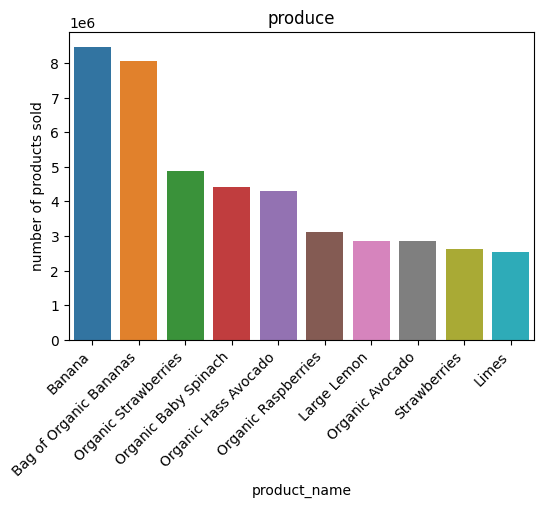

In [31]:
best_sellers_dept(df,'produce', 10)

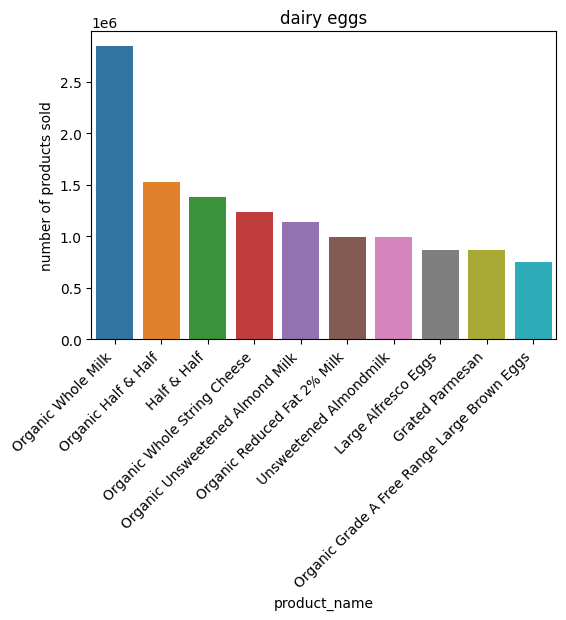

In [32]:
best_sellers_dept(df,'dairy eggs', 10)

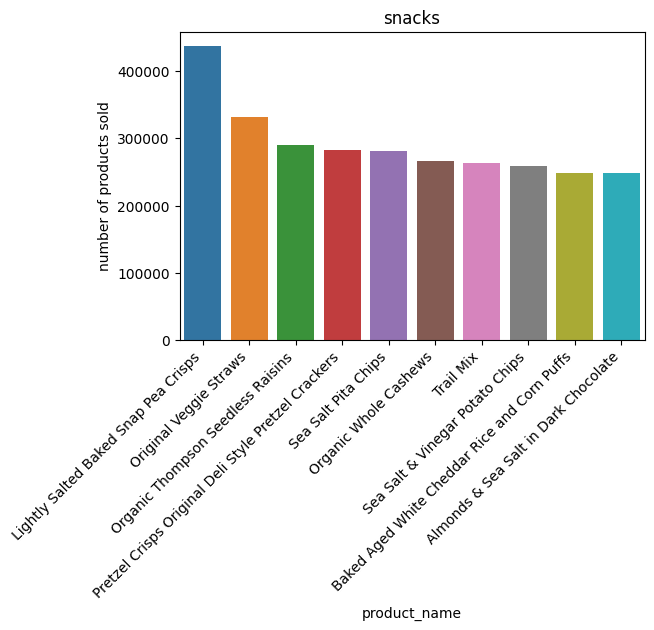

In [33]:
best_sellers_dept(df,'snacks', 10)

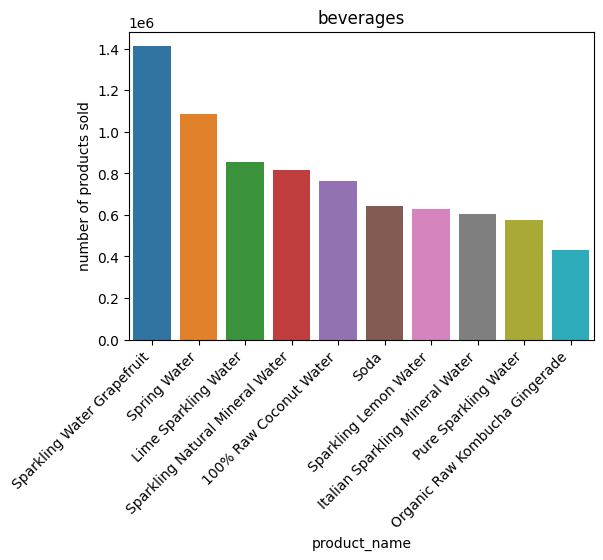

In [34]:
best_sellers_dept(df,'beverages', 10)

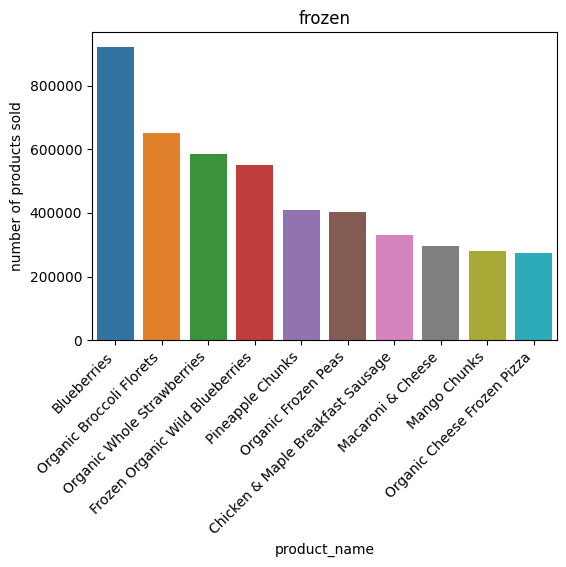

In [35]:
best_sellers_dept(df,'frozen', 10)

There seem to be rich information in **product_name**. We could do some text analysis to uncover the likes of instacart customers and finer partitions within the department. Hold on and be patient, as we will extract more information from product_name in the next part!

### reorder analysis
1. most reordered products
2. for each product, what are the reorder rates?
3. how many customers have reordered at least once? number of reordered products per customer?

In [36]:
# randomly pick some customers and see what they purchase
# df.loc[df.user_id == 6789,:]

In [37]:
# df.loc[df.user_id == 34,:]

In [38]:
reorder_products = df.groupby('product_name').agg(number_of_reorders=('reordered', np.sum),
                                                  number_of_orders=('reordered', len),
                                                  reorder_rate=('reordered', np.mean))
reorder_products

,number_of_reorders,number_of_orders,reorder_rate
product_name,,,
#2 Coffee Filters,265,799,0.331665
#2 Cone White Coffee Filters,3,14,0.214286
#2 Mechanical Pencils,0,9,0.000000
#4 Natural Brown Coffee Filters,90,247,0.364372
& Go! Hazelnut Spread + Pretzel Sticks,93,174,0.534483
...,...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,17,41,0.414634
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,20,57,0.350877
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,34,74,0.459459


In [39]:
k = 20
reorder_products.sort_values(by='number_of_reorders',ascending=False)[:k]

,number_of_reorders,number_of_orders,reorder_rate
product_name,,,
Banana,415166,491291,0.845051
Bag of Organic Bananas,329275,394930,0.833755
Organic Strawberries,214448,275577,0.778178
Organic Baby Spinach,194939,251705,0.774474
Organic Hass Avocado,176173,220877,0.797607
Organic Avocado,140270,184224,0.761410
Organic Whole Milk,118684,142813,0.831045
Large Lemon,112178,160792,0.697659
Organic Raspberries,109688,142603,0.769184


Some familiar names appear again. The most reordered products are pretty much the same as most purchased products. (Mostly fresh produce)

In [40]:
# reorder rate of products
reorder_products.sort_values(by='reorder_rate',ascending=False)[:k]

,number_of_reorders,number_of_orders,reorder_rate
product_name,,,
Raw Veggie Wrappers,65,69,0.942029
Serenity Ultimate Extrema Overnight Pads,84,90,0.933333
Orange Energy Shots,12,13,0.923077
Chocolate Love Bar,94,102,0.921569
Soy Powder Infant Formula,32,35,0.914286
Simply Sleep Nighttime Sleep Aid,41,45,0.911111
"Energy Shot, Grape Flavor",20,22,0.909091
Russian River Valley Reserve Pinot Noir,27,30,0.900000
Bars Peanut Butter,62,69,0.898551


What does higher reorder rate indicate?
From the result, products with high reorder rate are not "popular" and have low sales amount. 

A hypotheses: Despite there are few lovers of the products, they are loyal customers and frequently reorder the same products.

In [41]:
# how many customers have reordered? number of reordered products per customer?
tmp = df.groupby('user_id').agg({'reordered':'sum'})

In [42]:
sum(tmp.reordered > 0)/len(tmp)

0.9907860471657396

<AxesSubplot: ylabel='Count'>

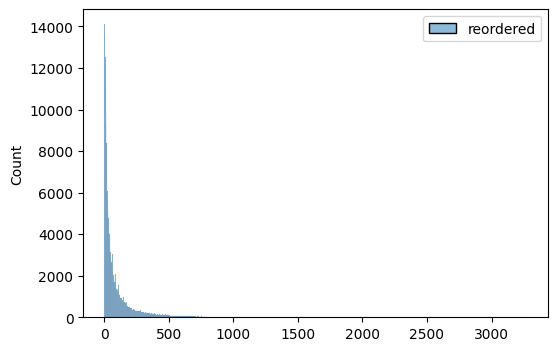

In [43]:
plt.figure(figsize=(6,4))
sns.histplot(tmp)

### customer analysis
1. number of orders per user
2. user preference 

<AxesSubplot: xlabel='order_id', ylabel='Count'>

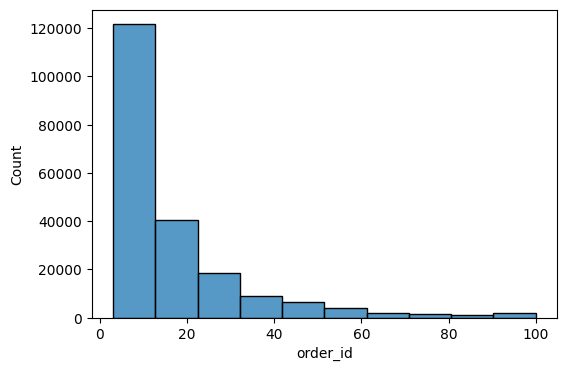

In [44]:
num_order_by_user = df.groupby('user_id')['order_id'].nunique()

plt.figure(figsize=(6,4))
sns.histplot(num_order_by_user,bins=10)

In [45]:
# most purchased category of customers

most_purchased = df.groupby(['user_id','department']).agg({'product_id':'count'}).reset_index()
most_purchased = most_purchased.rename(columns={'product_id':'distinct_product_count'})
most_purchased['rank'] = most_purchased.groupby('user_id')['distinct_product_count'].rank(method="dense", ascending=False)
dept_popularity = most_purchased.loc[most_purchased['rank'] == 1,'department'].value_counts()
dept_popularity

produce            121658
dairy eggs          33499
beverages           18313
snacks              14047
frozen              10794
pantry               3933
household            3651
alcohol              2216
babies               1366
personal care        1310
canned goods         1127
bakery               1083
deli                  986
breakfast             782
dry goods pasta       638
meat seafood          549
pets                  525
international         103
missing                25
other                  22
bulk                    9
Name: department, dtype: int64

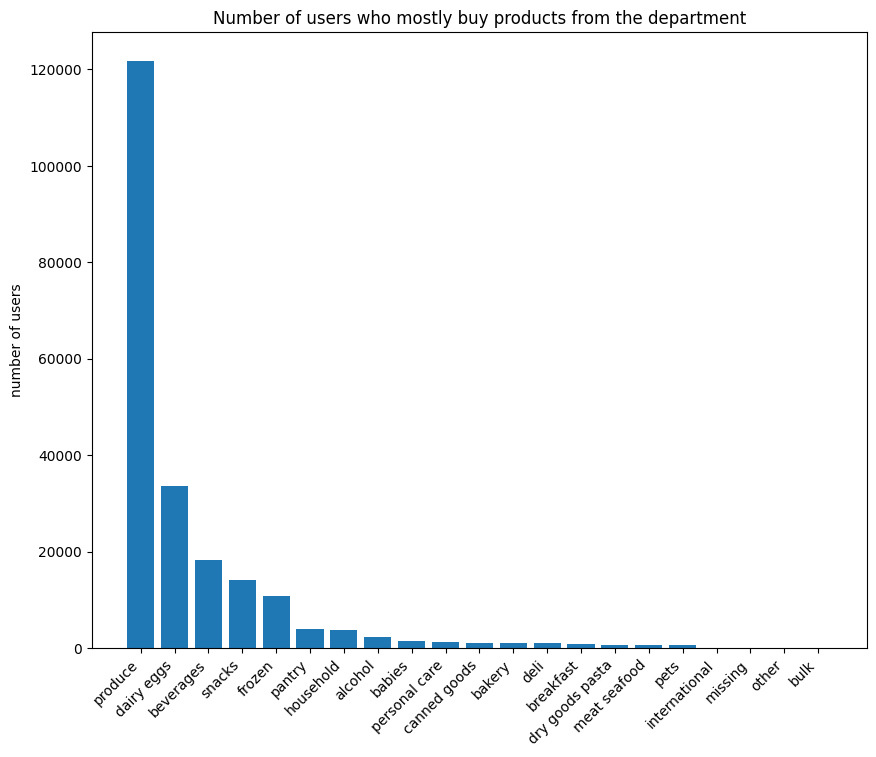

In [46]:
plt.figure(figsize = (10,8))
plt.bar(x=dept_popularity.index, height=dept_popularity);
plt.title('Number of users who mostly buy products from the department')
plt.ylabel('number of users')
plt.xticks(rotation=45, ha='right');

In [47]:
df.loc[df.department=='dairy eggs','product_name'].unique()

array(['Organic Unsweetened Vanilla Almond Milk', 'Organic String Cheese',
       'Organic Half & Half', ...,
       'Yogurt, Greek, Nonfat, Strained, Blended with Strawberry',
       'Original Shreds',
       'Lowfat Cherry Lime Supernova Kefir Cultured Milk Smoothie'],
      dtype=object)

In [48]:
df.loc[df.department=='beverages','product_name'].unique()

array(['Soda', 'Zero Calorie Cola', 'Organic Just Concord Grape Juice',
       ..., 'Pomegranate Mint Chia Vitality Beverage',
       'Organic Chocolate Mint Caffeine Free Tea', 'Orange Energy Shots'],
      dtype=object)

In [49]:
df.loc[df.department=='other','product_name'].unique()

array(['Zero Calorie Tonic Water', 'Crushed Chili', '93/7 Ground Beef',
       'Whole Bay Leaves', 'Light CocoWhip! Coconut Whipped Topping',
       'Raw Walnuts', 'Organic Whole Wheat Couscous',
       '3mg Melatonin Dietary Supplement Tablets - 240 CT',
       'Deluxe Nut Mix', 'Traditional Panettone',
       'PM Simply Sleep Nighttime Sleep Aid Caplets',
       'Classic Vanilla Coffee Creamer',
       'Cherry Nighttime Instant Teething Pain Relief Gel',
       'Facial Tissues with Lotion',
       'Melatonin TR, Time Release, 1 mg, Tablets',
       'Early Result Pregnancy Test', 'Liquid Teething Relief',
       'Original Pickle', 'Giraffes Diapers Size 4 L',
       'Kick It Immune For Kids Drops', 'Baby Healing Ointment',
       'Max AAA Batteries', 'Peppermint Essential Oil',
       'Roasted Salted Pistachios', 'Walnuts',
       'PM Pain Reliever and Nighttime Sleep Aid Caplets',
       'Roasted Almond Butter', 'BabyRub® Soothing Ointment',
       'Rapid Relief Creamy Diaper Rash Oi

**Conclusion**

Fresh produce the most ordered products at instacart, followed by dairy, beverages, snacks, frozen, and pantry (all foods). Followed by food, people bought household, which consists of  daily consumables.

It will result in imbalanced segmentation if we treat products the popular department homogeneously (especially in produce), and we are missing rich within-department information as well. Therefore, we should further differentiate products within department level.

In the next section, we will take a closer look at the *produce* department.

In [50]:
df.to_pickle('df.pkl')